In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from sklearn.model_selection import train_test_split

In [28]:
# Import training data (2400 observatios, each with dimension 12288)
"""
X_train = pd.read_csv("Train_data.csv",header=None)
# Import testing data (600 observatios, each with dimension 12288)
X_test = pd.read_csv("Test_data.csv",header=None)

# Import 2400 training labels and 600 testing labels
Y_train = pd.read_csv("Train_labels.csv",header=None)
Y_test = pd.read_csv("Test_labels.csv",header=None)
"""
X = torch.tensor(pd.read_csv("Test_data.csv").to_numpy())
Y = torch.tensor(pd.read_csv("Test_labels.csv").to_numpy())

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [29]:
print('Imported data size: ')
print(X_train.shape)
print(X_test.shape)

sz = X_train.shape
L = int(sz[1]/3)
X_train = X_train.reshape(479,L, 3)
X_test = X_test.reshape(120,L, 3)
print(X_train.shape)
print(X_test.shape)
X_train = X_train.transpose(1, 2)
X_test = X_test.transpose(1, 2)
print('Reshaped data size: ')
print(X_train.shape)
print(X_test.shape)

Imported data size: 
torch.Size([479, 12288])
torch.Size([120, 12288])
torch.Size([479, 4096, 3])
torch.Size([120, 4096, 3])
Reshaped data size: 
torch.Size([479, 3, 4096])
torch.Size([120, 3, 4096])


tensor([0])


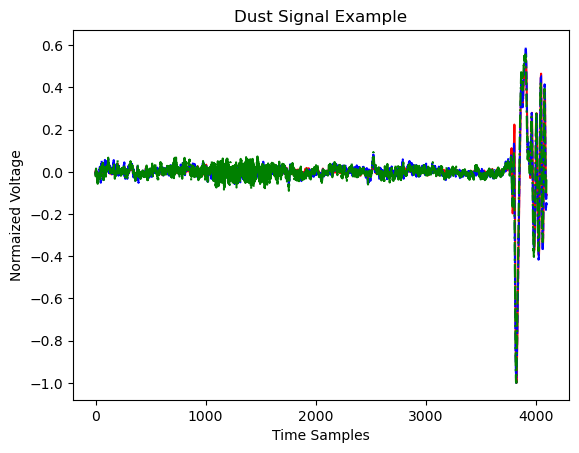

In [30]:
showNR = 8
antenna1 = X_train[showNR,0,:]
antenna2 = X_train[showNR,1,:]
antenna3 = X_train[showNR,2,:]
print(Y_train[showNR])
plt.plot(antenna1,'r-')
plt.plot(antenna2,'b--')
plt.plot(antenna3,'g-.')
plt.title('Dust Signal Example')
plt.xlabel('Time Samples')
plt.ylabel('Normaized Voltage')
plt.show()

In [31]:
class ConvNet(nn.Module):
    def __init__(self, input_shape):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=3, out_channels=128, kernel_size=8, stride=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.tensor(x, dtype=self.conv1.weight.dtype).to(device)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)

        return x

model = ConvNet(input_shape=X_train.shape[1:]).to(device)

# Numer of times to run through the training data
epochs = 225
# Number of samples to run through before updating the network parameters 
batch_size = 64


In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    running_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = torch.Tensor(X_train[i:i+batch_size]).to(device)
        labels = torch.Tensor(Y_train[i:i+batch_size]).long()[:,0].to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute accuracy on validation set
    with torch.no_grad():
        inputs = torch.Tensor(X_train[i:i+batch_size]).to(device)
        labels = torch.Tensor(Y_train[i:i+batch_size]).long()[:,0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        accuracy = 100 * correct / total

    print('Epoch %d loss: %.3f accuracy: %.3f' %
          (epoch + 1, running_loss / len(X_train), accuracy))

tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1])


c:\Users\ludwi\anaconda3\envs\Bachelor\lib\site-packages\ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0])
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1])
tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1])
tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1])


KeyboardInterrupt: 

In [ ]:
# Put your model into evaluation mode
model.eval()

# Compute accuracy on test set
with torch.no_grad():
    inputs = torch.Tensor(X_test).to(device)
    labels = torch.Tensor(Y_test).long()[:,0].to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    accuracy = 100 * correct / total

print('Accuracy on test set: {:.2f}%'.format(accuracy))

In [ ]:
def crossentropy(G, Y):
    # convert labels to onehot encoding
    Y_onehot = torch.eye(2, device=device)[Y]

    return -(Y_onehot * G.log()).sum(dim = 1).mean()

def accuracy(G, Y):
    return (G.argmax(dim=1) == Y).float().mean()

trainset = [[X_train[i], Y_train[i]] for i in range(len(Y_train))]

In [ ]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []

# initialize the neural network and move it to the GPU if needed
net = ConvNet(input_shape=X_train.shape[1:])
net.to(device)

# define the optimization algorithm
learningrate = 0.003
optimizer = optim.Adam(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 5000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        loss = crossentropy(batch_G, batch_Y)
        #loss = F.cross_entropy(batch_G[:,0], batch_Y)

        # backpropagation
        loss.backward()
        
        # perform gradient descent step
        optimizer.step()
        
        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)
                
            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = X_test.to(device), Y_test.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(crossentropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")
            
        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

c:\Users\ludwi\anaconda3\envs\Bachelor\lib\site-packages\ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Step     0: train accuracy  35.00% train cross-entropy 38.53  test accuracy  46.25% test cross-entropy 42.17


KeyboardInterrupt: 